<a href="https://colab.research.google.com/github/nomnomnonono/Image-Completion/blob/main/GLCIC/calculate_fid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Dec 15 05:19:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## ライブラリの読み込み

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/experiment/final")

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torchvision.utils import save_image

import json
import torchsummary
import numpy as np
import os

from datasets import ImageDataset
from fid import fid_torch
from models import CompletionNetwork
from utils import sample_random_batch, generate_mask, define_hole_area, get_completion_image

## 初期設定

In [ ]:
data_dir = "img_align_celeba"
result_dir = "/content/drive/MyDrive/Colab Notebooks/experiment/final/result"
device = torch.device('cuda')
bsize = 32
cn_input_size = 120
resize = 299

cn_path = os.path.join(result_dir, 'phase_3', 'cn_step400000.pth')
model_cn = CompletionNetwork()
model_cn.load_state_dict(torch.load(cn_path, map_location='cpu'))

<All keys matched successfully>

## 画像の読み込み

In [ ]:
!mkdir train test

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/experiment/final/img_align_celeba.zip" "."
!unzip -q img_align_celeba.zip
!mv img_align_celeba/2* test/

In [ ]:
!ls "img_align_celeba" -1 | wc -l
!ls "test" -1 | wc -l

199999
2600


## mpvの読み込み

In [ ]:
mpv_json = open(os.path.join(result_dir, 'config.json'), 'r')
mpv_data = json.load(mpv_json)
mpv = mpv_data['mpv']
mpv = np.array(mpv)

In [ ]:
mpv = torch.tensor(mpv.reshape(1, 3, 1, 1), dtype=torch.float32).to(device)

## データセット

In [ ]:
transform = transforms.Compose([
        transforms.Resize(cn_input_size),
        transforms.RandomCrop((cn_input_size, cn_input_size)),
        transforms.ToTensor(),
])

train = ImageDataset('img_align_celeba', transform)
train_loader = DataLoader(train, batch_size=bsize, shuffle=True)
test = ImageDataset('test', transform)

## Inception v3の読み込み

In [ ]:
model = models.inception_v3(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
model.dropout = torch.nn.Identity()
model.fc = torch.nn.Identity()

In [ ]:
torchsummary.summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [ ]:
model = model.eval()

## CompletionNetworkの読み込み

In [ ]:
model_cn = CompletionNetwork().to(device)
model_cn.load_state_dict(torch.load(cn_path, map_location='cpu'))
model_cn.eval()

CompletionNetwork(
  (conv1): Conv2d(4, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act4): ReLU()
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act5): ReLU()
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(

## 実行

In [ ]:
x = sample_random_batch(test, batch_size=bsize).to(device)
# false
mask = generate_mask((bsize, 1, 120, 120), hole_size=((36,72),(36,72)),
                     hole_area=define_hole_area((72,72),(120,120))[0]).to(device)
x_mask = x - x*mask + mpv*mask
x_in = torch.cat((x_mask, mask), dim=1)
x_out = model_cn(x_in)
x_inpaint = get_completion_image(x_mask, x_out, mask).to(device)

In [ ]:
torch_score = fid_torch(model, x, x_inpaint, device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
torch_score

38.121981179433

In [ ]:
save_image(x_inpaint, os.path.join(result_dir, 'a.png'), nrow=32)

In [ ]:
out = x_inpaint.detach().cpu().numpy()
out = out.transpose(0, 2, 3, 1)
out.shape

(32, 120, 120, 3)

In [ ]:
img = x.detach().cpu().numpy()
img = img.transpose(0, 2, 3,1)
img.shape

(32, 120, 120, 3)

In [ ]:
import matplotlib.pyplot as plt

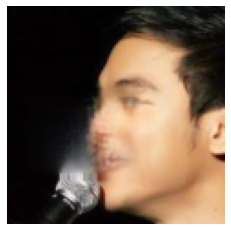

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False)
for i in range(bsize):
  ax.imshow(out[i, :, :, :])
  ax.axis('off')
  fig.savefig(os.path.join(result_dir, 'valid', 'o{}.png'.format(i)))

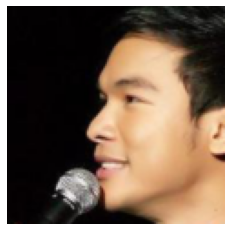

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False)
for i in range(bsize):
  ax.imshow(img[i, :, :, :])
  ax.axis('off')
  fig.savefig(os.path.join(result_dir, 'valid', 'i{}.png'.format(i)))